In [1]:
# Import library
import streamlit as st
import pandas as pd
from io import StringIO
import re
import nltk
import csv
import string
string.punctuation
from nltk import word_tokenize 
from nltk.probability import FreqDist
# nltk.download('punkt')
# nltk.download('brown')
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import swifter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('D:\WFH\BOOTCAMP\Challenge platinum\data\data.tsv', sep='\t', header=None)

In [3]:
txt = pd.DataFrame(df)
txt = txt.rename(columns={0 : 'text', 1 : 'label'})
txt = txt.groupby(['label']).apply(lambda x: x.sample(n=1000, random_state=42))
txt = txt.drop(index='neutral')

In [4]:
def remove_tweet_special(text):
    # remove tab, new line, ans back slice
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
    # remove non ASCII (emoticon, chinese word, .etc)
    text = text.encode('ascii', 'replace').decode('ascii')
    # remove mention, link, hashtag
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    # remove incomplete URL
    return text.replace("http://", " ").replace("https://", " ")

#remove number
def remove_number(text):
    return  re.sub(r"\d+", "", text)

#defining the function to remove punctuation
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree

#remove whitespace leading & trailing
def remove_whitespace_LT(text):
    return text.strip()

#remove multiple whitespace into single whitespace
def remove_whitespace_multiple(text):
    return re.sub('\s+',' ',text)

# remove single char
def remove_singl_char(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)

# NLTK word tokenize 
def word_tokenize_wrapper(text, language="indonesia"):
    return word_tokenize(text)

# NLTK calc frequency distribution
def freqDist_wrapper(text):
    return FreqDist(text)

# # Stemming
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming(text):
    text = [stemmer.stem(word) for word in text]
    return text

# Join token
def join_token(text):
    text = ' '.join(text)
    return text

# ----------------------- get stopword from Sastrawi ------------------------------------
# get stopword indonesia
stop_factory = StopWordRemoverFactory()

# ---------------------------- manualy add stopword  ------------------------------------
more_stopword = ["yg", "dg", "rt", "dgn", "ny", "d", 'klo', 
                'kalo', 'amp', 'biar', 'bikin', 'bilang', 
                'gak', 'ga', 'gk', 'krn', 'nya', 'nih', 'sih', 
                'si', 'tau', 'tdk', 'tuh', 'utk', 'ya', 
                'jd', 'jgn', 'sdh', 'aja', 'n', 't', 
                'nyg', 'hehe', 'pen', 'u', 'nan', 'loh', 'rt',
                '&amp', 'yah', 'user']
# ---------------------------------------------------------------------------------------
# append additional stopword

list_stopwords = stop_factory.get_stop_words()+more_stopword
stopword = stop_factory.create_stop_word_remover()

# convert list to dictionary
list_stopwords = set(list_stopwords)

#remove stopword pada list token
def stopwords_removal(words):
    return [word for word in words if word not in list_stopwords]

# ---------------------------------------------------------------------------------------

kamus = pd.read_csv(r'D:\WFH\BOOTCAMP\Challenge platinum\data\new_kamusalay.csv', encoding = 'latin-1', sep=',', header=None)
if kamus is not None:  
    # Can be used wherever a "file-like" object is accepted:
    ids_before = kamus
    ids_before = ids_before.set_index(0).to_dict()
    ids = dict(ele for sub in ids_before.values() for ele in sub.items())

import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [5]:
txt['clean'] = txt['text'].str.lower()
txt['clean'] = txt['clean'].apply(remove_punctuation)
txt['clean'] = txt['clean'].apply(remove_tweet_special)
txt['clean'] = txt['clean'].apply(remove_number)
txt['clean'] = txt['clean'].apply(remove_whitespace_LT)
txt['clean'] = txt['clean'].apply(remove_whitespace_multiple)
txt['clean'] = txt['clean'].apply(remove_singl_char)
txt['clean'] = txt['clean'].apply(word_tokenize_wrapper)

# Normalized with dictionary
def normalized_term(text):
    return [ids[term] if term in ids else term for term in text]

# txt['clean'] = txt['clean'].apply(normalized_term)
# txt['clean'] = txt['clean'].apply(stopwords_removal)
# txt['clean'] = txt['clean'].apply(stemming)
token = txt['clean']
# txt['clean'] = txt['clean'].apply(join_token)
txt['label_num'] = txt['label'].apply(lambda score: 0 if score=='positive' else 1 if score=='negative' else 2)

In [6]:
df = txt[['clean', 'label_num']].reset_index(drop=True)
df['clean'] = df['clean'].astype(str)

vec = TfidfVectorizer().fit(df['clean'])
vec_transform = vec.transform(df['clean'])

# Train test split
# X = vec_transform.toarray()
X = df['clean']
y = df['label_num']

# Membagi data menjadi set pelatihan dan sisa data (validasi + pengujian)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Melihat jumlah data dalam setiap set
print("Jumlah data set pelatihan:", len(X_train))
print("Jumlah data set pengujian:", len(X_test))

Jumlah data set pelatihan: 1600
Jumlah data set pengujian: 400


In [7]:
def flatten_list(nested_list):
    flattened_list = []
    for item in nested_list:
        if isinstance(item, list):
            flattened_list.extend(flatten_list(item))
        else:
            flattened_list.append(item)
    return flattened_list

token = flatten_list(token)

In [8]:
from keras.preprocessing.text import one_hot, Tokenizer
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPool1D, Embedding, Conv1D, LSTM, SpatialDropout1D
from keras import layers

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

# vocab_length = len(word_tokenizer.word_index) + 1
vocab_length = 10000

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

from keras.utils import pad_sequences

maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [9]:
# Neural network architecture

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_length, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           500000    
                                                                 
 global_max_pooling1d (Globa  (None, 50)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                510       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 500,521
Trainable params: 500,521
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 1.0000
Testing Accuracy:  0.8725


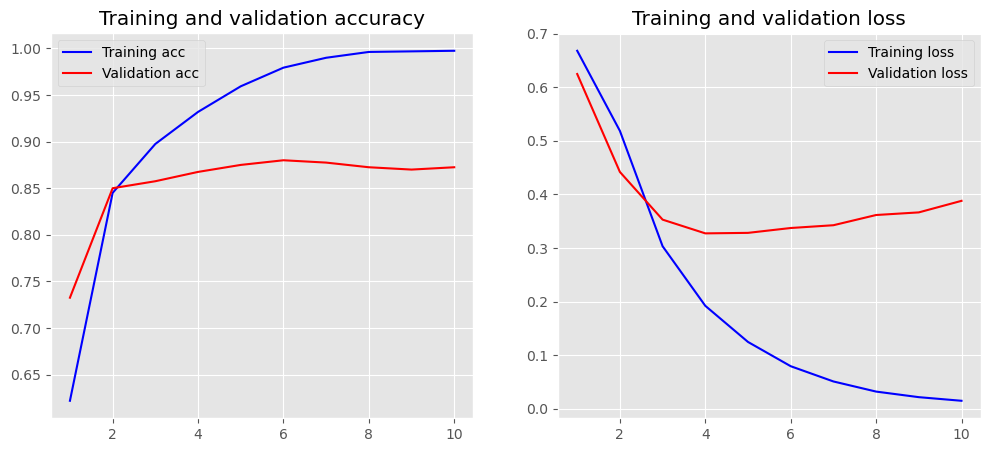

In [10]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

model.save("model_nn_nostem.h5")

from keras.backend import clear_session
clear_session()

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [11]:
# Neural Network architecture

from keras.layers import LSTM

embedding_dim = 50

lstm_model = Sequential()
lstm_model.add(layers.Embedding(input_dim=vocab_length, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
lstm_model.add(LSTM(50, return_sequences = True))
lstm_model.add(Dropout(0.1))
lstm_model.add(layers.GlobalMaxPool1D())
lstm_model.add(Dropout(0.1))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])
lstm_model.summary()

history = lstm_model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=8)

lstm_model.save("model_lstm_nostem.h5")

from keras.backend import clear_session
clear_session()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           500000    
                                                                 
 lstm (LSTM)                 (None, 100, 50)           20200     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 global_max_pooling1d (Globa  (None, 50)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                        

Training Accuracy: 0.9950
Testing Accuracy:  0.8300


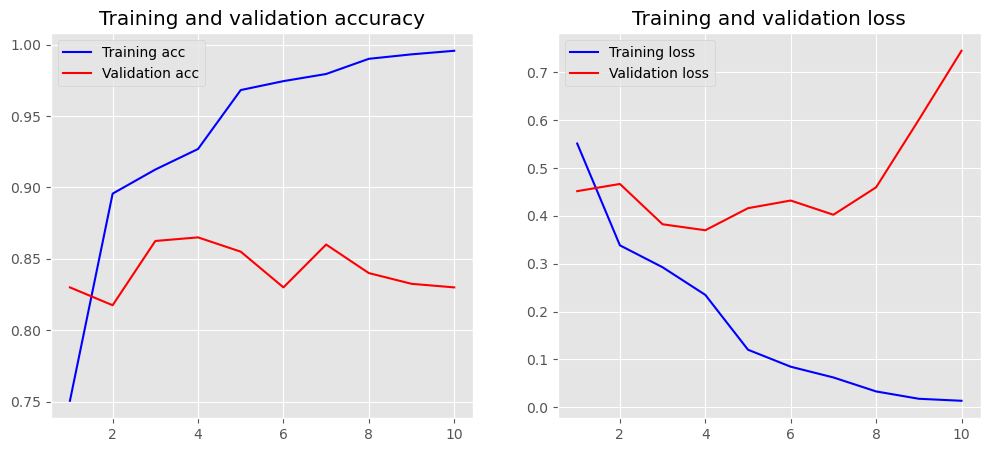

In [12]:
loss, accuracy = lstm_model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = lstm_model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [13]:
# Predict data baru

text = pd.read_csv(r'D:\WFH\BOOTCAMP\Challenge platinum\data\redbus.csv')
text.drop(columns='No', inplace=True)
text['content'] = text['content'].astype(str)
text['content'] = text['content'].str.lower()
text['label_true'] = text['Label'].apply(lambda score: 0 if score=='Positif' else 1 if score=='Negatif' else 2)

text['clean'] = text['content'].apply(remove_punctuation)
text['clean'] = text['clean'].apply(remove_tweet_special)
text['clean'] = text['clean'].apply(remove_number)
text['clean'] = text['clean'].apply(remove_whitespace_LT)
text['clean'] = text['clean'].apply(remove_whitespace_multiple)
text['clean'] = text['clean'].apply(remove_singl_char)
text['clean'] = text['clean'].apply(word_tokenize_wrapper)
# text['clean'] = text['clean'].apply(normalized_term)
# text['clean'] = text['clean'].apply(stopwords_removal)
# text['clean'] = text['clean'].apply(stemming)
token_predict = text['clean']
# txt['clean'] = txt['clean'].apply(join_token)
text['label_num'] = text['label_true']

In [14]:
df_predict = text[['clean', 'label_num']].reset_index(drop=True)
df_predict['clean'] = df_predict['clean'].astype(str)   

# vec = TfidfVectorizer().fit(df_predict['clean'])
vec_transform = vec.transform(df_predict['clean'])

X_predict = df_predict['clean']
y_predict = df_predict['label_num']

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_predict)

# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

X_predict = word_tokenizer.texts_to_sequences(X_predict)

X_predict = pad_sequences(X_predict, padding='post', maxlen=maxlen)

from tensorflow import keras

model = keras.models.load_model("model_nn_nostem.h5")
predict = model.predict(X_predict, verbose=0)

loss, accuracy = model.evaluate(X_predict, y_predict, verbose=False)
print("Accuracy: {:.4f}".format(accuracy))

Accuracy: 0.5020


In [15]:
import numpy as np

df_predict['prediction'] = np.round(predict, decimals=0).astype(int)
df_predict

,clean,label_num,prediction
0,"['app', 'nya', 'lancar', 'bagusgk', 'ribet', '...",0,0
1,"['bagus', 'dan', 'sangat', 'membentu']",0,0
2,"['aplikasi', 'sangat', 'membantu', 'pemesanan'...",0,1
3,"['mudah', 'senang', 'easy']",0,1
4,"['mantap', 'banyak', 'potongan', 'harga', 'tik...",0,0
...,...,...,...
495,"['pemesanan', 'yg', 'praktis', 'dengan', 'perj...",0,1
496,"['aplikasi', 'keren', 'yg', 'adminnya', 'aktif...",0,0
497,"['cara', 'mudah', 'pesen', 'tiket', 'bis', 'sa...",0,0
498,"['sangat', 'bagus', 'dan', 'membantu', 'perjal...",0,0
